# Analysis of Candidate Costimulatory Domains

In [1]:
import pandas as pd
from pathlib import Path

import costim_screen as cs

## Define Paths to Data and Results

In [2]:
base_path = Path('/Users/cordessf/OneDrive/ACI/Repositories/CostimScreen')
data_path = base_path / 'data'
results_path = base_path / 'results'
results_path.mkdir(parents=True, exist_ok=True)

candidate_metadata_path = data_path / 'candidate_metadata.xlsx'
counts_path = data_path / 'merged_counts.xlsx'
elm_annotation_path = data_path / 'costim_normalized_elms_groupings.xlsx'
sample_metadata_path = data_path / 'sample_metadata.xlsx'
topology_metadata_path = data_path / 'costim_topol_protein_families.xlsx'

## Prepare Metadata

In [3]:
# Construct sample metadata from counts column names
smeta = cs.sample_metadata_from_counts_xlsx(
    counts_path,
    out_xlsx=sample_metadata_path,
    strict=True,
)

# Construct candidate metadata
cand = cs.merge_candidate_metadata(
    elm_annotation_path,
    topology_metadata_path,
    out_xlsx=candidate_metadata_path,
)

# ELM design matrix (with optional quadratic interactions)
X_elm = cs.build_elm_category_design(
    cand,
    include_quadratic=True,
    min_freq=0.0, # 0.01,
    min_interaction_freq=0.0, # 0.01,  # tweak if you want more/less aggressive interaction pruning
)

## Load Inputs

In [4]:
counts_wide = cs.load_counts_matrix(counts_path, candidate_id_col="CandidateID")
smeta = cs.load_sample_metadata(sample_metadata_path)
cand = cs.load_candidate_metadata(candidate_metadata_path)

# ---- Align IDs and columns
common_candidates = counts_wide.index.intersection(cand.index)
common_samples = counts_wide.columns.intersection(smeta.index)

counts_wide = counts_wide.loc[common_candidates, common_samples]
cand = cand.loc[common_candidates]
smeta = smeta.loc[common_samples]

## Filter Low-signal candidates

In [5]:
counts_wide = cs.filter_domains_by_total_counts(counts_wide, min_total=50)
cand = cand.loc[counts_wide.index]

## Build ELM design

In [6]:
X_elm = cs.build_elm_category_design(
    cand.reset_index(),
    candidate_id_col="CandidateID",
    elm_col="ELMCategory",
    include_quadratic=False,           # No pairwise interactions
    min_freq=0.0,                      # Threshold disabled
)

# Make patsy-safe column names
safe_cols, mapping = cs.make_patsy_safe_columns(list(X_elm.columns), prefix="ELM_")
X_elm = X_elm.rename(columns=mapping)
pd.Series(mapping).to_csv(results_path / "elm_feature_name_map.csv")

print(f"Number of ELM features: {len(X_elm.columns)}")

# Restrict inferential analysis to non-GPCR
non_gpcr_ids = cand.index[cand["is_gpcr"] == 0]
counts_wide = counts_wide.loc[non_gpcr_ids]
X_elm = X_elm.loc[non_gpcr_ids]
cand = cand.loc[non_gpcr_ids]

# Sample-level derived variables
smeta = smeta.copy()
smeta.index.name = "sample_id"  # Ensure index name is preserved
smeta["Tsubset"] = smeta["Tsubset"].replace({"Naïve": "Naive"})
smeta["phenotype"] = smeta["Tsubset"].astype(str) + "_" + smeta["PD1Status"].astype(str)
smeta["CCR"] = cs.make_ccr_id(smeta)

# Long table + offset
df = cs.counts_to_long(counts_wide, id_col="CandidateID")
df = df.merge(smeta.reset_index(), on="sample_id", how="left")
df = cs.add_library_size(df)

# Attach ELM features
df = df.merge(X_elm.reset_index().rename(columns={"index": "CandidateID"}), on="CandidateID", how="left")

# Drop incomplete rows
df = df.dropna(subset=["phenotype", "CCR", "offset", "count"])

# Let's look at what we have...
df

Number of ELM features: 49


,CandidateID,sample_id,count,Donor,ExpCond,Tsubset,PD1Status,Replicate,phenotype,CCR,...,TRAF6,TRFH,TYR,UBA3,USP7,WD40,WRC,WW,deltaCOP1,eIF4E
0,ACKR1-1,1_Act CAR_CM_High_1,6147,1,Act CAR,CM,High,1,CM_High,1_Act CAR_r1,...,0,0,0,0,0,1,0,0,0,0
1,ACKR1-1,1_Act CAR_CM_High_2,3645,1,Act CAR,CM,High,2,CM_High,1_Act CAR_r2,...,0,0,0,0,0,1,0,0,0,0
2,ACKR1-1,1_Act CAR_CM_High_3,6901,1,Act CAR,CM,High,3,CM_High,1_Act CAR_r3,...,0,0,0,0,0,1,0,0,0,0
3,ACKR1-1,1_Act CAR_CM_Low_1,11547,1,Act CAR,CM,Low,1,CM_Low,1_Act CAR_r1,...,0,0,0,0,0,1,0,0,0,0
4,ACKR1-1,1_Act CAR_CM_Low_2,13711,1,Act CAR,CM,Low,2,CM_Low,1_Act CAR_r2,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142987,ZDHHC5-1,2_CAR_Naïve_High_2,0,2,CAR,Naive,High,2,Naive_High,2_CAR_r2,...,0,0,0,0,1,1,1,1,0,0
142988,ZDHHC5-1,2_CAR_Naïve_High_3,0,2,CAR,Naive,High,3,Naive_High,2_CAR_r3,...,0,0,0,0,1,1,1,1,0,0
142989,ZDHHC5-1,2_CAR_Naïve_Low_1,0,2,CAR,Naive,Low,1,Naive_Low,2_CAR_r1,...,0,0,0,0,1,1,1,1,0,0
142990,ZDHHC5-1,2_CAR_Naïve_Low_2,0,2,CAR,Naive,Low,2,Naive_Low,2_CAR_r2,...,0,0,0,0,1,1,1,1,0,0


# Analyze CAR:Raji

In [7]:
df_raji = df[df["ExpCond"] == "CAR:Raji"].copy()
df_raji["phenotype"] = pd.Categorical(df_raji["phenotype"])

motif_cols = [c for c in X_elm.columns]
formula = cs.build_joint_formula(motif_cols)

fit = cs.fit_nb_glm_iter_alpha(df_raji, formula=formula, offset_col="offset", cluster_col="CCR")

with open(results_path / "glm_summary.txt", "w") as f:
    f.write(str(fit.res.summary()))
(pd.Series({"alpha": fit.alpha})).to_csv(results_path / "alpha.csv")

assert getattr(fit.res, "cov_type", None) == "cluster", "Fit did not use cluster-robust SEs."

print("Estimated alpha:", fit.alpha)

Estimated alpha: 1.0866703214458338


## Plot Volcano Plots

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'EM_High vs CM_High (Raji)  |  alpha=1.09'}, xlabel='$\\log_2$ fold change', ylabel='$-\\log_{10}$ q-value'>)

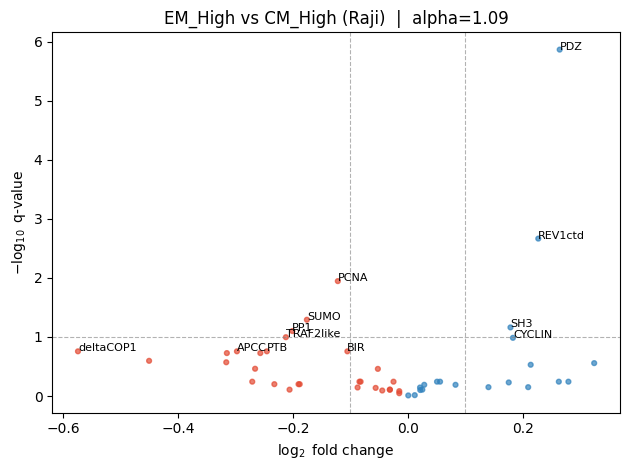

In [8]:
# Choose the contrast you want
p = "EM_High"
q = "CM_High"

res = cs.motif_contrast_table(
    fit,
    motifs=motif_cols,
    p=p,
    q=q,
    adjust="BH",
    log_base=2.0,
)

res.to_csv(results_path / f"volcano_table_{p}_vs_{q}.csv", index=False)

title = f"{p} vs {q} (Raji)  |  alpha={fit.alpha:.3g}"
cs.volcano_plot(
    res,
    q_thresh=0.10,
    lfc_thresh=0.10,
    title=title,
    top_n_labels=12,
    outpath=results_path / f"volcano_{p}_vs_{q}.png",
)

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'EM_High vs EM_Low (Raji)  |  alpha=1.09'}, xlabel='$\\log_2$ fold change', ylabel='$-\\log_{10}$ q-value'>)

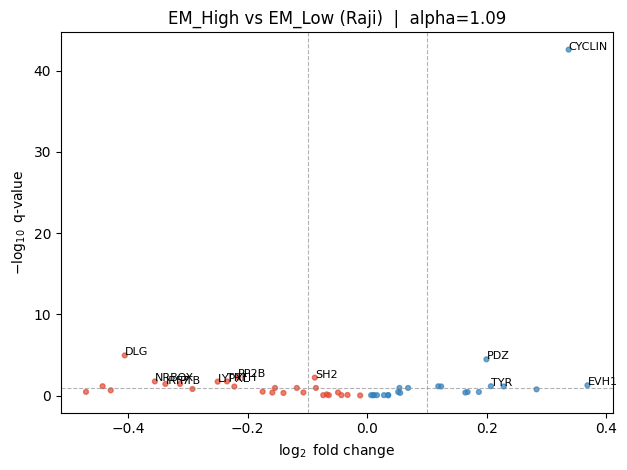

In [9]:
# Choose the contrast you want
p = "EM_High"
q = "EM_Low"

res = cs.motif_contrast_table(
    fit,
    motifs=motif_cols,
    p=p,
    q=q,
    adjust="BH",
    log_base=2.0,
)

res.to_csv(results_path / f"volcano_table_{p}_vs_{q}.csv", index=False)

title = f"{p} vs {q} (Raji)  |  alpha={fit.alpha:.3g}"
cs.volcano_plot(
    res,
    q_thresh=0.10,
    lfc_thresh=0.10,
    title=title,
    top_n_labels=12,
    outpath=results_path / f"volcano_{p}_vs_{q}.png",
)

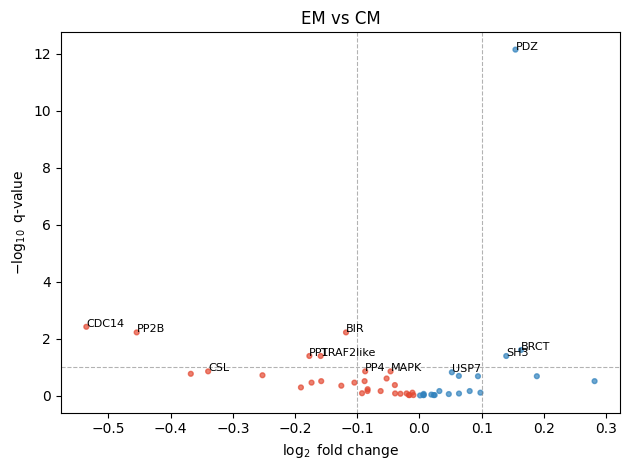

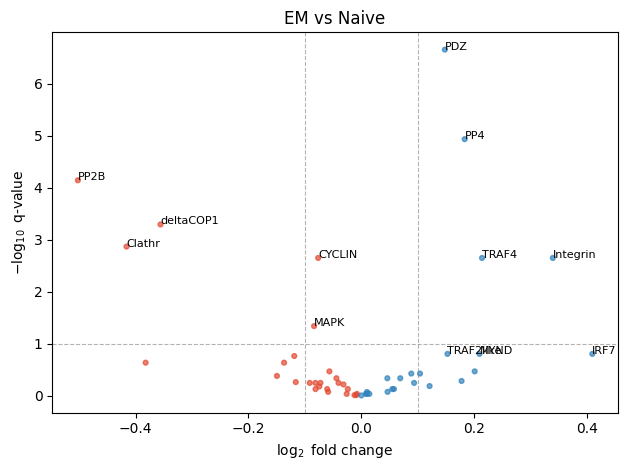

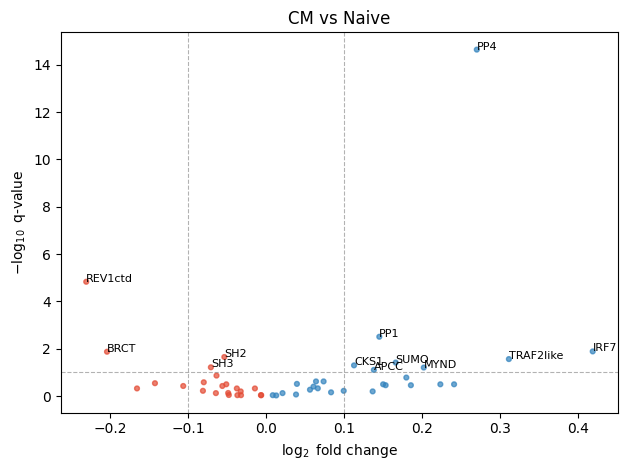

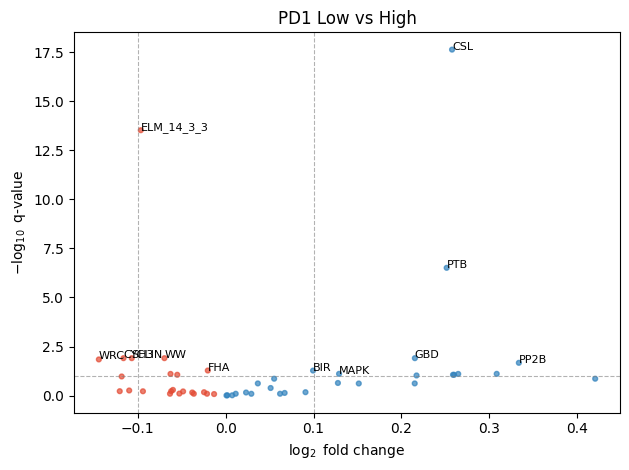

In [15]:
motifs = motif_cols  # your patsy-safe ELM features

# Tsubset comparisons pooled over PD1
# ... EM versus CM
tab_em_vs_cm = cs.volcano_tsubset_pooled_pd1(
    fit,
    motifs,
    tsubset_p="EM",
    tsubset_q="CM",
    q_thresh=0.10,
    lfc_thresh=0.1,
    title=f"EM vs CM",
    outpath=results_path / "volcano_EM_vs_CM_pooledPD1.png",
)
tab_em_vs_cm.to_csv(results_path / "table_EM_vs_CM_pooledPD1.csv", index=False)

# ... EM versus Naive
tab_em_vs_naive = cs.volcano_tsubset_pooled_pd1(
    fit,
    motifs,
    tsubset_p="Naive",
    tsubset_q="CM",
    q_thresh=0.10,
    lfc_thresh=0.1,
    title=f"EM vs Naive",
    outpath=results_path / "volcano_Naive_vs_CM_pooledPD1.png",
)
tab_em_vs_naive.to_csv(results_path / "table_EM_vs_Naive_pooledPD1.csv", index=False)

# ... CM versus Naive
tab_cm_vs_naive = cs.volcano_tsubset_pooled_pd1(
    fit,
    motifs,
    tsubset_p="Naive",
    tsubset_q="EM",
    q_thresh=0.10,
    lfc_thresh=0.10,
    title=f"CM vs Naive",
    outpath=results_path / "volcano_Naive_vs_EM_pooledPD1.png",
)
tab_cm_vs_naive.to_csv(results_path / "table_CM_vs_Naive_pooledPD1.csv", index=False)

# PD1 comparisons pooled over Tsubset
tab_pd1 = cs.volcano_pd1_pooled_tsubset(
    fit,
    motifs,
    tsubsets=("Naive", "CM", "EM"),
    pd1_high="Low",
    pd1_low="High",
    q_thresh=0.10,
    lfc_thresh=0.10,
    title=f"PD1 Low vs High",
    outpath=results_path / "volcano_PD1Low_vs_PD1High_pooledTsubset.png",
)
tab_pd1.to_csv(results_path / "table_PD1High_vs_PD1Low_pooledTsubset.csv", index=False)

# Plot Pooled Heatmap

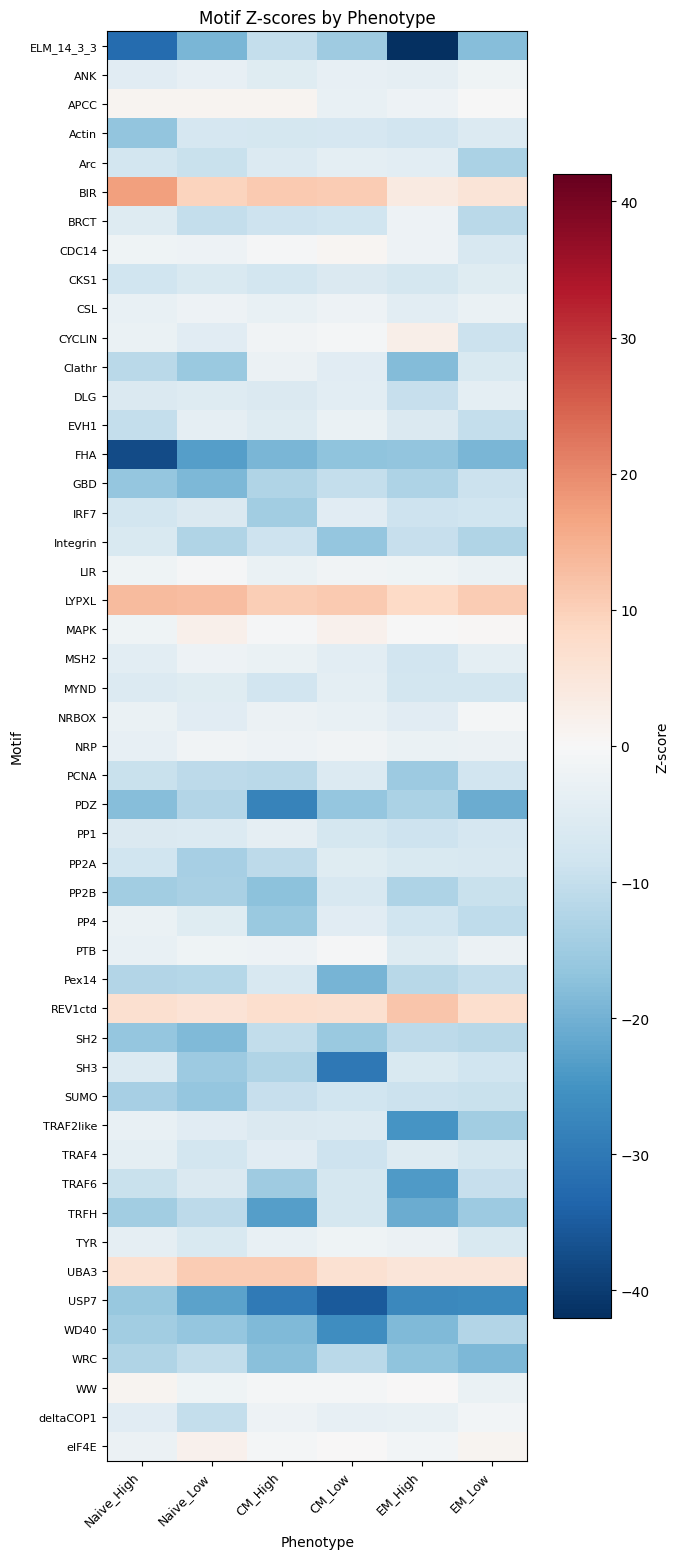

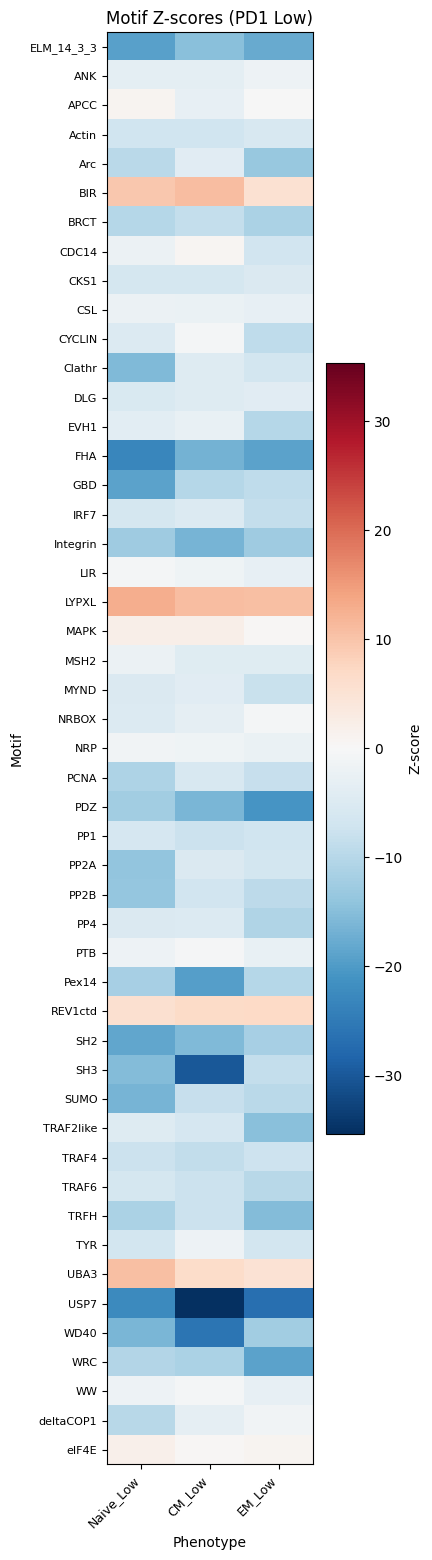

In [11]:
# Heatmap of Z-scores across all phenotypes
fig, ax, data = cs.coef_heatmap(
    fit,
    motifs=motif_cols,
    phenotypes=["Naïve_High", "Naïve_Low", "CM_High", "CM_Low", "EM_High", "EM_Low"],
    value="z",
    title="Motif Z-scores by Phenotype"
)

# Or just the coarse phenotypes with PD1_Low
fig, ax, data = cs.coef_heatmap(
    fit,
    motifs=motif_cols,
    phenotypes=["Naïve_Low", "CM_Low", "EM_Low"],
    value="z",
    title="Motif Z-scores (PD1 Low)"
)

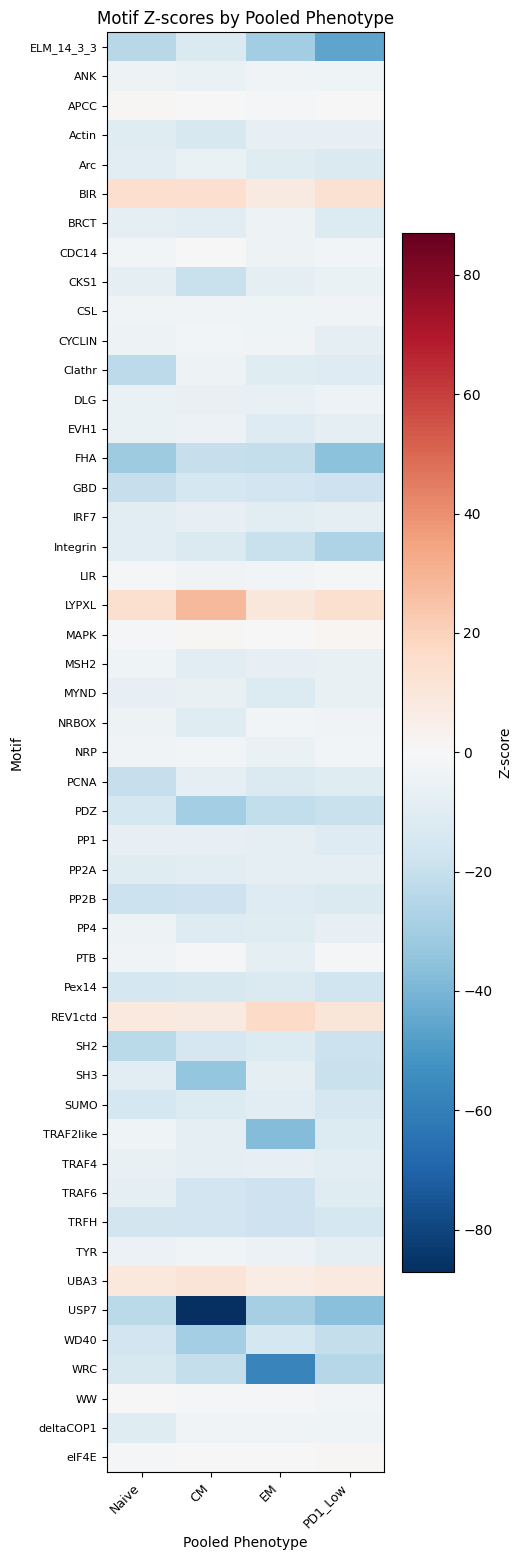

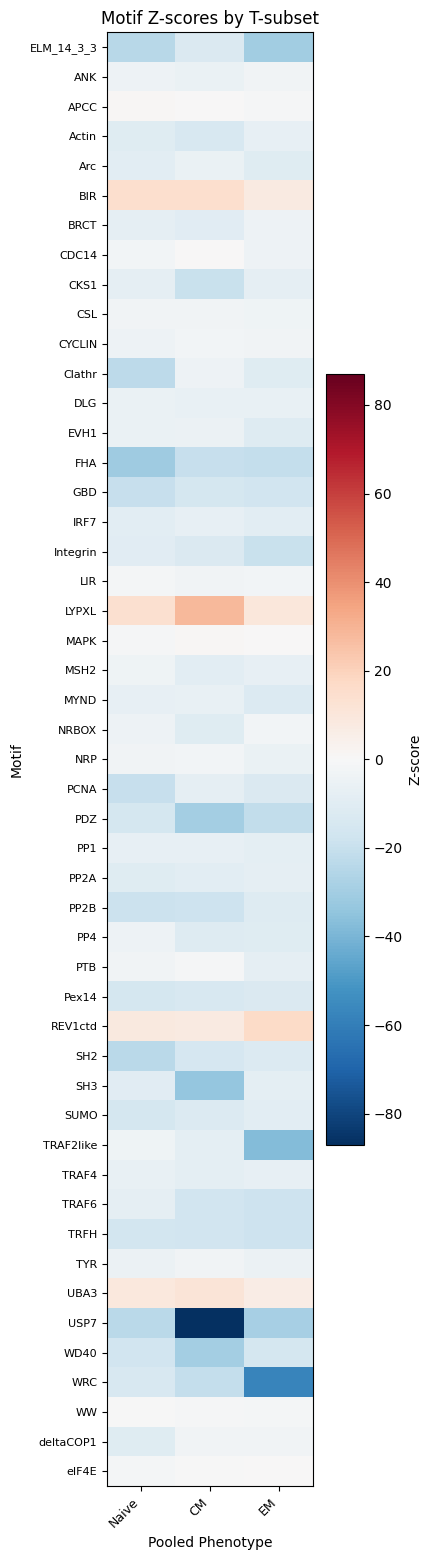

In [16]:
# Heatmap with pooled phenotypes
fig, ax, data = cs.pooled_coef_heatmap(
    fit,
    motifs=motif_cols,
    title="Motif Z-scores by Pooled Phenotype",
    outpath=results_path / "heatmap_pooled.png",
    dpi=300,
)

# Without the PD1_Low column
fig, ax, data = cs.pooled_coef_heatmap(
    fit,
    motifs=motif_cols,
    include_pd1_low=False,
    title="Motif Z-scores by T-subset"
)

## Assemble the 2 x 2 volcano grid + right-hand heatmap panel

In [17]:
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

def assemble_costim_main_figure(
    results_path: str | Path,
    *,
    volcano_em_vs_cm="volcano_EM_vs_CM_pooledPD1.png",
    volcano_naive_vs_cm="volcano_Naive_vs_CM_pooledPD1.png",
    volcano_naive_vs_em="volcano_Naive_vs_EM_pooledPD1.png",
    volcano_pd1low_vs_high="volcano_PD1Low_vs_PD1High_pooledTsubset.png",
    heatmap_pooled="heatmap_pooled.png",
    out_png="figure_volcanos_plus_heatmap.png",
    out_pdf="figure_volcanos_plus_heatmap.pdf",
    dpi=300,
    width_ratios=(4.0, 1.2),  # ~77% vs ~23%
):
    results_path = Path(results_path)
    paths = {
        "A": results_path / volcano_em_vs_cm,
        "B": results_path / volcano_naive_vs_cm,
        "C": results_path / volcano_naive_vs_em,
        "D": results_path / volcano_pd1low_vs_high,
        "E": results_path / heatmap_pooled,
    }

    missing = [k for k, p in paths.items() if not p.exists()]
    if missing:
        raise FileNotFoundError(
            "Missing expected figure files:\n"
            + "\n".join([f"  {k}: {paths[k]}" for k in missing])
        )

    imgs = {k: mpimg.imread(str(p)) for k, p in paths.items()}

    fig = plt.figure(figsize=(14, 8))
    outer = fig.add_gridspec(
        nrows=2, ncols=2,
        width_ratios=list(width_ratios),
        height_ratios=[1, 1],
        wspace=0.02, hspace=0.05,
    )

    left = outer[:, 0].subgridspec(nrows=2, ncols=2, wspace=0.05, hspace=0.08)

    axA = fig.add_subplot(left[0, 0])
    axB = fig.add_subplot(left[0, 1])
    axC = fig.add_subplot(left[1, 0])
    axD = fig.add_subplot(left[1, 1])
    axE = fig.add_subplot(outer[:, 1])

    for ax, key in [(axA,"A"), (axB,"B"), (axC,"C"), (axD,"D"), (axE,"E")]:
        ax.imshow(imgs[key])
        ax.axis("off")
        ax.text(
            0.01, 0.99, key,
            transform=ax.transAxes,
            ha="left", va="top",
            fontweight="bold",
            fontsize=14,
        )

    out_png_path = results_path / out_png
    fig.savefig(out_png_path, dpi=dpi, bbox_inches="tight")
    if out_pdf is not None:
        fig.savefig(results_path / out_pdf, bbox_inches="tight")
    plt.close(fig)

    return out_png_path

assemble_costim_main_figure(results_path)

PosixPath('/Users/cordessf/OneDrive/ACI/Repositories/CostimScreen/results/figure_volcanos_plus_heatmap.png')